In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x


def attention_gate(x, g, filters):
    x1 = layers.Conv2D(filters, (1, 1), padding='same')(x)
    g1 = layers.Conv2D(filters, (1, 1), padding='same')(g)
    
    out = layers.add([x1, g1])
    out = layers.ReLU()(out)
    out = layers.Conv2D(1, (1, 1), padding='same')(out)
    out = layers.Activation('sigmoid')(out)
    
    return layers.multiply([x, out])


2024-08-18 18:14:15.377206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 18:14:16.363196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-08-18 18:14:16.363303: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
def unet_v3(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Downsampling
    c1 = residual_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = residual_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = residual_block(p4, 1024)
    
    # Upsampling with attention
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = attention_gate(c4, u6, 512)
    u6 = layers.concatenate([u6, c4])
    c6 = residual_block(u6, 512)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = attention_gate(c3, u7, 256)
    u7 = layers.concatenate([u7, c3])
    c7 = residual_block(u7, 256)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = attention_gate(c2, u8, 128)
    u8 = layers.concatenate([u8, c2])
    c8 = residual_block(u8, 128)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = attention_gate(c1, u9, 64)
    u9 = layers.concatenate([u9, c1])
    c9 = residual_block(u9, 64)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [9]:
import numpy as np

# train_dataset = np.load("../../numpy_arr_data/train_img.npy")
# mask_dataset = np.load("../../numpy_arr_data/vegetation_mask_img.npy")

# # Prepare your dataset as before
train_images = [tf.image.resize(images, (128, 128)).numpy() for images in train_dataset]
train_masks = [tf.image.resize(mask, (128, 128)).numpy() for mask in mask_dataset]

2024-08-18 18:22:46.641008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-18 18:22:46.675991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-18 18:22:46.678109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-18 18:22:46.680876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [10]:
# Convert lists to numpy arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

train_images.shape, train_masks.shape

((2975, 128, 128, 3), (2975, 128, 128, 3))

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray_mask = []
for mask in train_masks:
    mask = rgb2gray(mask)
    mask[mask<0.5]=0
    mask[mask>=0.5]=1
    gray_mask.append(mask) 
    
gray_mask = np.array(gray_mask)
gray_mask = gray_mask[...,np.newaxis]
    
    
gray_image = []
for image in train_images:
    image = rgb2gray(image)
    gray_image.append(image) 
    
gray_image = np.array(gray_image)
gray_image = gray_image[...,np.newaxis]

In [35]:
gray_image.shape, gray_mask.shape

((2975, 128, 128, 1), (2975, 128, 128, 1))

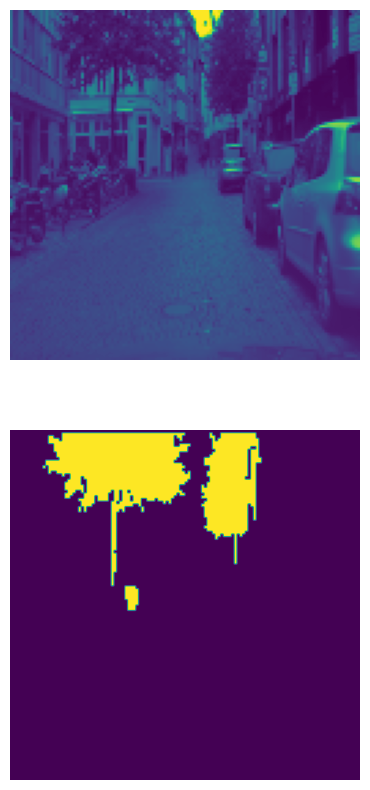

In [55]:
import matplotlib.pyplot as plt

# Example list of images (replace with your actual images)
images = [gray_image[0], gray_mask[0]]  # Replace with your actual images

# Number of images
num_images = len(images)

# Determine the grid size (e.g., 2 rows, 3 columns for 6 images)
rows = 2
cols = (num_images + 1) // 2

# Create a figure
plt.figure(figsize=(10, 10))

# Loop through the images and add each to a subplot
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.axis('off')  # Hide the axis

# Show the plot
plt.show()

In [59]:
model.save('../model/mobile_unet.keras')

In [47]:
from sklearn.model_selection import train_test_split

# Assuming resized_images and resized_masks have the shape (500, 128, 128, 1)
X_train, X_val, y_train, y_val = train_test_split(gray_image, gray_mask, test_size=0.1, random_state=42)


In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import cv2

# Step 2: Define data augmentation
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the augmenters
image_datagen.fit(gray_image, augment=True)
mask_datagen.fit(gray_mask, augment=True)

# Combine the image and mask generators
def image_mask_generator(image_gen, mask_gen, gray_image, gray_mask, batch_size):
    seed = 42
    image_gen = image_gen.flow(images, batch_size=batch_size, seed=seed)
    mask_gen = mask_gen.flow(masks, batch_size=batch_size, seed=seed)
    
    while True:
        yield (next(image_gen), next(mask_gen))


In [44]:
batch_size = 32
train_generator = image_mask_generator(image_datagen, mask_datagen, gray_image, gray_mask, batch_size)

In [48]:
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()

# Create validation generators
val_image_generator = val_image_datagen.flow(X_val, batch_size=batch_size, seed=42)
val_mask_generator = val_mask_datagen.flow(y_val, batch_size=batch_size, seed=42)

# Combine the image and mask generators for training and validation
val_generator = zip(val_image_generator, val_mask_generator)

In [49]:
# Step 3: Define the model
input_shape = (128, 128, 1)
model = unet_v3(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 5: Train the model using the generator
history = model.fit(
    train_generator,
    steps_per_epoch=len(gray_image) // batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/30
92/92 [==============================] - 84s 734ms/step - loss: 0.2542 - accuracy: 0.8712 - val_loss: 0.4177 - val_accuracy: 0.8646
Epoch 2/30
92/92 [==============================] - 54s 588ms/step - loss: 0.1771 - accuracy: 0.9109 - val_loss: 0.5191 - val_accuracy: 0.8654
Epoch 3/30
92/92 [==============================] - 54s 586ms/step - loss: 0.1648 - accuracy: 0.9165 - val_loss: 0.2412 - val_accuracy: 0.8874
Epoch 4/30
92/92 [==============================] - 54s 586ms/step - loss: 0.1492 - accuracy: 0.9224 - val_loss: 0.2565 - val_accuracy: 0.8813
Epoch 5/30
92/92 [==============================] - 54s 586ms/step - loss: 0.1454 - accuracy: 0.9240 - val_loss: 0.1576 - val_accuracy: 0.9358
Epoch 6/30
92/92 [==============================] - 54s 585ms/step - loss: 0.1414 - accuracy: 0.9258 - val_loss: 0.1986 - val_accuracy: 0.9107
Epoch 7/30
92/92 [==============================] - 54s 585ms/step - loss: 0.1370 - accuracy: 0.9278 - val_loss: 0.1964 - val_accuracy: 0.9206

In [50]:
model.save('../model/mobile_unet_data_manipulation.keras')

In [51]:
import numpy as  np
test_image = np.load("../../numpy_arr_data/test_img.npy")
mask_image = np.load("../../numpy_arr_data/test_vegetation_mask_gray_img.npy")

In [52]:
mask_image = mask_image[...,np.newaxis]

In [53]:
test_image = [tf.image.resize(images, (128, 128)).numpy() for images in test_image]
mask_image = [tf.image.resize(mask, (128, 128)).numpy() for mask in mask_image]

test_image = np.array(test_image)
mask_image = np.array(mask_image)

test_image.shape, mask_image.shape

((500, 128, 128, 3), (500, 128, 128, 1))

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
gray_image_test = []
for image in test_image:
    image = rgb2gray(image)
    gray_image_test.append(image) 
    
gray_image_test = np.array(gray_image_test)
gray_image_test = gray_image_test[...,np.newaxis]

In [55]:
gray_image_test.shape

(500, 128, 128, 1)

In [56]:
predicted = model.predict(gray_image_test, verbose=1)

16/16 [==============================] - 7s 423ms/step


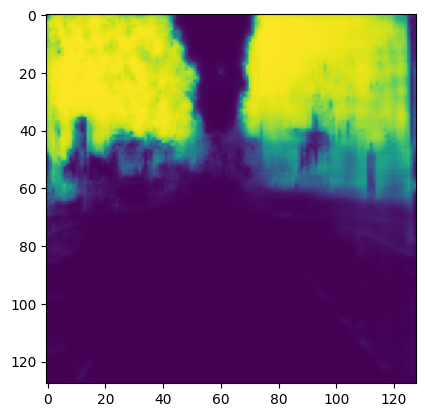

In [57]:
plt.imshow(predicted[0])

In [58]:
pred_mask = []
for mask in predicted:
    # mask = rgb2gray(mask)
    mask[mask<0.5]=0
    mask[mask>=0.5]=1
    pred_mask.append(mask) 

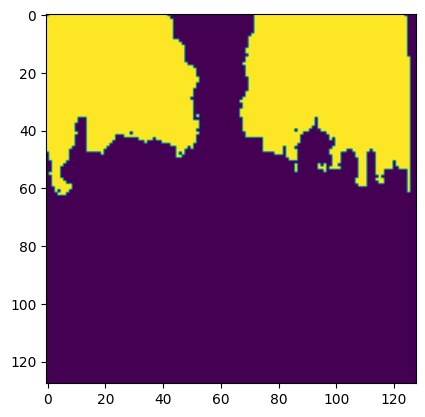

In [59]:
plt.imshow(pred_mask[0])

### Testing Unet v3 model

In [60]:
def calculating_iou(true_mask, pred_mask):
    arr_iou=[]
    for i in range(len(true_mask)):
        intersection = np.logical_and(true_mask[i],pred_mask[i])
        union = np.logical_or(true_mask[i], pred_mask[i])
        iou_score = np.sum(intersection) / np.sum(union)
        arr_iou.append(iou_score)
    arr_iou=np.array(arr_iou)
    arr_iou= np.nan_to_num(arr_iou, copy=True, nan=1.0)
    mean_iou=arr_iou.mean()
    return mean_iou

calculating_iou(mask_image, pred_mask)

/var/tmp/ipykernel_71974/1095475470.py:6: RuntimeWarning: invalid value encountered in scalar divide
  iou_score = np.sum(intersection) / np.sum(union)


0.583561743843941